# How to use `indigopy`

Example code for how to use the `indigopy` package. The sample data used in this example notebook is derived from the [INDIGO](https://doi.org/10.1007/978-1-4939-8891-4_13), [INDIGO-MTB](https://doi.org/10.1128/mbio.02627-19), and [MAGENTA](https://doi.org/10.1371/journal.pcbi.1006677) publications.  

## Set up environment

In [1]:
# Import dependencies
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Import package functions
import sys
sys.path.append('c:/Users/carol/github/INDIGOpy/') # modify if testing locally in different machine; remove once package is published
from indigopy.core import load_sample, featurize, classify

## Example: *E. coli*

The following analysis and results were originally reported in the [INDIGO](https://doi.org/10.1007/978-1-4939-8891-4_13) paper.  
- **Training dataset**: 105 two-way interactions between 15 antibiotics  
- **Testing dataset**: 66 two-way interactions between the 15 antibiotics in the training set + 4 new antibiotics  

In [2]:
# Load sample data
sample = load_sample('ecoli')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (-0.5, 2), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

Defining INDIGO features: 100%|██████████| 66/66 [00:00<00:00, 464.53it/s]


Regression results:
	Spearman R = 0.6575
	Spearman p = 2e-09
	R2 = 0.3895
Classification results:
              precision    recall  f1-score   support

           A       0.50      0.31      0.38        13
           N       0.68      0.90      0.78        42
           S       0.50      0.09      0.15        11

    accuracy                           0.65        66
   macro avg       0.56      0.43      0.44        66
weighted avg       0.61      0.65      0.59        66



## Example: *M. tuberculosis*

The following analysis and results were originally reported in the [INDIGO-MTB](https://doi.org/10.1128/mbio.02627-19) paper.  
- **Training dataset**: 196 two- to five-way interactions between 40 antibacterials  
- **Testing dataset**: 36 two- to three-way interactions between the 13 antibacterials  
- **Clinical dataset**: clinical outcomes for 57 two- to five-way interactions between 7 antibacterials  

In [3]:
# Load sample data
sample = load_sample('mtb')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']
clinical_ixns   = sample['clinical']['interactions']
clinical_scores = sample['clinical']['scores']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True)
clinical_data   = featurize(clinical_ixns, profiles, feature_names=feature_names, key=key, silent=True)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()
X_clinical      = clinical_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (0.9, 1.1), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

# Apply model to clinical data
clinical_y = reg_model.predict(X_clinical)
r, p = spearmanr(clinical_scores, clinical_y)
print('Clinical results:')
print('\tSpearman R = {}'.format(round(-r, 4)))
print('\tSpearman p = {:.3g}'.format(p))

Defining INDIGO features: 100%|██████████| 57/57 [00:00<00:00, 552.91it/s]


Regression results:
	Spearman R = 0.5348
	Spearman p = 0.000779
	R2 = 0.122
Classification results:
              precision    recall  f1-score   support

           A       0.62      0.31      0.42        16
           N       0.00      0.00      0.00         1
           S       0.73      0.84      0.78        19

    accuracy                           0.58        36
   macro avg       0.45      0.38      0.40        36
weighted avg       0.66      0.58      0.60        36

Clinical results:
	Spearman R = 0.5035
	Spearman p = 6.55e-05


## Example: *S. aureus*

The following analysis and results were originally reported in the [INDIGO](https://doi.org/10.1007/978-1-4939-8891-4_13) paper.  
- **Training dataset**: 171 two-way interactions between 19 antibiotics measured in *E. coli*  
- **Testing dataset**: 45 two-way interactions between the 10 antibiotics measured in *S. aureus*  

In [4]:
# Load sample data
sample = load_sample('saureus')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']
strains         = sample['orthology']['strains']
orthology_map   = sample['orthology']['map']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True, 
                            strains=strains, orthology_map=orthology_map)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (-0.5, 2), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

Mapping orthologous genes: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Regression results:
	Spearman R = 0.5428
	Spearman p = 0.000117
	R2 = -1.257
Classification results:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           N       0.49      1.00      0.66        22
           S       0.00      0.00      0.00        21

    accuracy                           0.49        45
   macro avg       0.16      0.33      0.22        45
weighted avg       0.24      0.49      0.32        45



c:\Users\carol\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Example: *A. baumannii*

The following analysis and results were originally reported in the [MAGENTA](https://doi.org/10.1371/journal.pcbi.1006677) paper.  
- **Training dataset**: 338 two- to three-way interactions between 24 antibiotics measured in *E. coli* cultured in various media conditions  
- **Testing dataset**: 45 two-way interactions between the 8 antibiotics measured in *A. baumannii*  

Mapping orthologous genes: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Regression results:
	Spearman R = 0.614
	Spearman p = 7.28e-06
	R2 = -0.3302
Classification results:
              precision    recall  f1-score   support

           A       0.43      0.94      0.59        17
           N       0.00      0.00      0.00        11
           S       0.86      0.35      0.50        17

    accuracy                           0.49        45
   macro avg       0.43      0.43      0.36        45
weighted avg       0.49      0.49      0.41        45



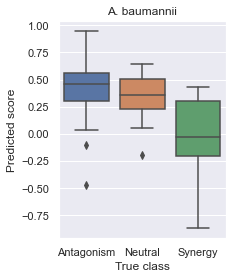

In [5]:
# Load sample data
sample = load_sample('abaumannii')

# Define input arguments
key             = sample['key']
profiles        = sample['profiles']
feature_names   = sample['feature_names']
train_ixns      = sample['train']['interactions']
train_scores    = sample['train']['scores']
test_ixns       = sample['test']['interactions']
test_scores     = sample['test']['scores']
strains         = sample['orthology']['strains']
orthology_map   = sample['orthology']['map']

# Determine ML features
train_data      = featurize(train_ixns, profiles, feature_names=feature_names, key=key, silent=True)
test_data       = featurize(test_ixns, profiles, feature_names=feature_names, key=key, silent=True, 
                            strains=strains, orthology_map=orthology_map)
X_train, X_test = train_data['feature_df'].to_numpy().transpose(), test_data['feature_df'].to_numpy().transpose()

# Determine class labels
thresh, classes = (-0.5, 0), ('S', 'N', 'A')
train_labels    = classify(train_scores, thresholds=thresh, classes=classes)
test_labels     = classify(test_scores, thresholds=thresh, classes=classes)

# Train and apply a regression-based model
reg_model = RandomForestRegressor()
reg_model.fit(X_train, train_scores)
reg_y = reg_model.predict(X_test)
r, p = spearmanr(test_scores, reg_y)
r2 = r2_score(test_scores, reg_y)
print('Regression results:')
print('\tSpearman R = {}'.format(round(r, 4)))
print('\tSpearman p = {:.3g}'.format(p))
print('\tR2 = {}'.format(round(r2, 4)))

# Train and apply a classification-based model
class_model = RandomForestClassifier()
class_model.fit(X_train, train_labels)
class_y = class_model.predict(X_test)
print('Classification results:')
print(classification_report(test_labels, class_y))

# Visualize results
df = pd.DataFrame({'x': test_labels, 'y': reg_y})
df.replace({'A': 'Antagonism', 'N': 'Neutral', 'S': 'Synergy'}, inplace=True)
sns.set(rc={'figure.figsize':(3, 4)})
ax = sns.boxplot(x='x', y='y', data=df, order=['Antagonism', 'Neutral', 'Synergy'], )
ax.set(title='A. baumannii', xlabel='True class', ylabel='Predicted score')
plt.show()